# Microbot Image Detector

Jupyter notebook designed to select an area of your screen and apply edge detection libraries to locate microbots in cell cultures

In [1]:
# enable ipympl backend for interactive matplotlib graphs
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import numpy as np
import cv2
import pyautogui
import pims
import trackpy as tp
import ipywidgets as widgets
from IPython.display import display
from utils.tp_plots import annotate  # module of modified trackpy plotting functions

### Trackpy Parameters

In [2]:
# declare default values for tracky parameters

diameter = 13
minmass = 1500
maxsize = None
threshold = 10
noise_size = 1
topn = None
separation = diameter + 1
smoothing_size = diameter

In [3]:
# Create accessible sliders for adjusting trackpy values

diameter_wid = widgets.IntSlider(value=diameter, min=1, max=100, step=2, description="Diameter")
minmass_wid = widgets.IntSlider(value=minmass, min=0, max=3000, step=1, description="Minmass")
maxsize_wid = widgets.IntSlider(value=-1 if maxsize is None else maxsize, min=-1, max=3000, step=1, description="Maxsize")
threshold_wid = widgets.IntSlider(value=10, min=1, max=100, step=1, description="Threshold")
noise_size_wid = widgets.FloatSlider(value=1, min=0, max=10, step=0.1, description="Noise Size")
topn_wid = widgets.IntSlider(value=-1 if topn is None else topn, min=-1, max=50, step=1, description="Top N")
separation_wid = widgets.IntSlider(value=14, min=0, max=1000, step=1, description="Separation")
smoothing_size_wid = widgets.IntSlider(value=13, min=1, max=1000, step=2, description="Smoothing Size")

# display widgets
display(
    diameter_wid,
    minmass_wid,
    maxsize_wid,
    threshold_wid,
    noise_size_wid,
    topn_wid,
    separation_wid,
    smoothing_size_wid
)

IntSlider(value=13, description='Diameter', min=1, step=2)

IntSlider(value=1500, description='Minmass', max=3000)

IntSlider(value=-1, description='Maxsize', max=3000, min=-1)

IntSlider(value=10, description='Threshold', min=1)

FloatSlider(value=1.0, description='Noise Size', max=10.0)

IntSlider(value=-1, description='Top N', max=50, min=-1)

IntSlider(value=14, description='Separation', max=1000)

IntSlider(value=13, description='Smoothing Size', max=1000, min=1, step=2)

### Screen Cropper

C:\Users\kerbu\AppData\Local\Temp\ipykernel_9960\3637444912.py:27: MatplotlibDeprecationWarning: 
The 'drawtype' parameter of __init__() was deprecated in Matplotlib 3.5 and will be removed two minor releases later. If any parameter follows 'drawtype', they should be passed as keyword, not positionally.
  rs = RectangleSelector(


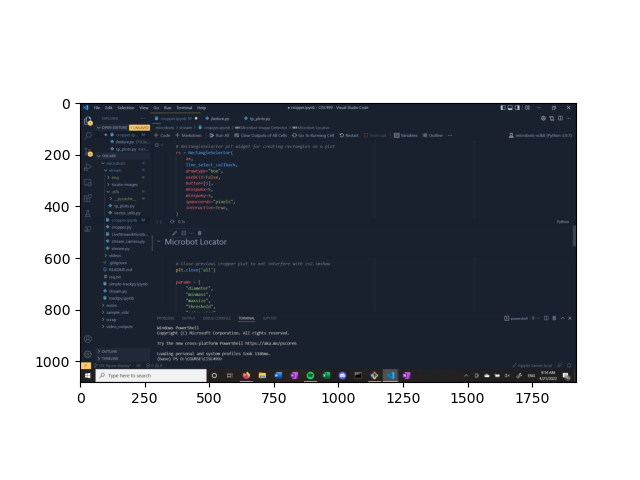

In [4]:
# take initial screenshot of screen
screenshot = pyautogui.screenshot()

# create global vars to save crop selection
LEFT, TOP, WIDTH, HEIGHT = 0, 0, 0, 0

fig, ax = plt.subplots()
ax.imshow(screenshot)

def line_select_callback(eclick, erelease):
    """Callback function for RectangleSelector; allows you to select a section
    of an initial screenshot and updates screen coordinates to be used by
    pyautogui.screenshot()"""

    # coordinates for pyautogui.screenshot()
    global LEFT, TOP, WIDTH, HEIGHT
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # store coordinates in global vars
    LEFT = min(x1, x2)
    TOP = min(y1, y2)
    WIDTH = np.abs(x1 - x2)
    HEIGHT = np.abs(y1 - y2)

# RectangleSelector plt widget for creating rectangles on a plot
rs = RectangleSelector(
    ax,
    line_select_callback,
    drawtype="box",
    useblit=False,
    button=[1],
    minspanx=5,
    minspany=5,
    spancoords="pixels",
    interactive=True,
)

### Microbot Locator

In [5]:
# Close previous cropper plot to not interfere with cv2.imshow
plt.close('all')

params = [
    "diameter",
    "minmass",
    "maxsize",
    "threshold",
    "noise_size",
    "topn",
    "separation",
    "smoothing_size"
]

# Get each parameter variable and set it to the widget value, converting
# negative vals to be a None parameter
for i in params:
    val = globals()[i + '_wid'].value
    if val < 0:
        val = None
    globals()[i] = val

# continuously take screenshots and annotate them with trackpy, displaying w/ cv2
while True:
    
    # take screenshot, convert to numpy array, grayscale, and convert to PIMS object
    img = pyautogui.screenshot(region = (LEFT, TOP, WIDTH, HEIGHT))
    frame = np.array(img)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    pim_gray = pims.frame.Frame(gray)   # turn grayscale into PIMS Frame object

    # get feature location DataFrame
    f = tp.locate(
        pim_gray,
        diameter=diameter,
        minmass=minmass,
        maxsize=maxsize,
        threshold=threshold,
        noise_size=noise_size,
        topn=topn,
        separation=separation,
        smoothing_size=smoothing_size,
        invert=True,
        engine="numba"
    )

    # Get plt figure generated by trackpy's annotate; requires pd.DataFrame and PIMS object
    fig = annotate(f, pim_gray).figure

    # remove margins and axes from figure to only get annotated figure image
    ax = fig.gca()
    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    # Draw image onto plt canvas and convert into a numpy ndarray
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    cv2.imshow('image', image_from_plot) # show annotated image
    fig.clear(True) # clear canvas for next preprocessed image
        

    # press q to quit program
    if cv2.waitKey(1) == ord("q"):
        break

# close all windows
cv2.destroyAllWindows()
plt.close('all')